In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from cv2 import HOGDescriptor

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tqdm import tqdm

In [4]:
# Image Directory
img_dir = "data"

# Data Groups
grps = ["train", "test"]

# Initializing a Dataframe to store paths and labels
column_names = ["ort", "grp", "path", "label", "label_int", "filename"]
data = pd.DataFrame(columns = column_names)

# For label
label_i = 0
for grp in grps:
    for path in sorted(os.listdir(img_dir +'/'+ grp)):
        if not path.startswith('.'):
            files = os.listdir(img_dir +'/'+ grp +'/'+ path)
            files = sorted(files, key = lambda x: int(x.split(".")[0]))
            for f in files:
                if (f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.jpg')):
                    for orientation in [0, 90, 180, 270]:
                        data_append = {"ort": orientation,
                                    "grp": grp,
                                    "path": img_dir +'/'+ grp +'/'+ path +'/'+ f,
                                    "label": path.split("_")[1],
                                    "label_int": int(path.split("_")[0]),
                                    "filename": f}
                        data = data.append(data_append, ignore_index = True)

# Printing Useful information
print("Data Shape: ", data.shape)
print("Labels: ", data.label.unique(), data.label_int.unique())

print("Dataset:")
data.head(3)

Data Shape:  (1200, 6)
Labels:  ['diode' 'resistor' 'inductor'] [0 1 2]
Dataset:


,ort,grp,path,label,label_int,filename
0,0,train,data/train/0_diode/1.jpeg,diode,0,1.jpeg
1,90,train,data/train/0_diode/1.jpeg,diode,0,1.jpeg
2,180,train,data/train/0_diode/1.jpeg,diode,0,1.jpeg


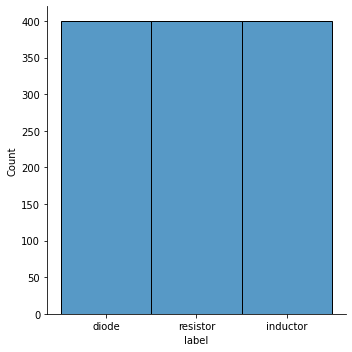

In [5]:
ax = sns.displot(data=data, x='label')

# Loading and Viewing Images

In [6]:
# Initializing images column
data['img_read'] = np.nan
data['img_read'] = data['img_read'].astype(object)

# Printing Info
print("[INFO] Importing Images")

# Iterating on all rows and reading image data
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img = cv2.imread(row.path, 0)
    data.at[index, 'img_read'] = img

[INFO] Importing Images


100%|██████████| 1200/1200 [00:00<00:00, 2794.42it/s]


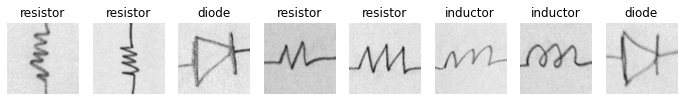

In [7]:
row = 1
col = 8

fig, axes = plt.subplots(row, col, figsize=(1.5*col,2*row))
for (index, data_sample), i in zip(data.sample(8).iterrows(), range(8)):
    ax = axes[i]
    ax.imshow(data_sample["img_read"], "gray")
    ax.set_title(data_sample.label)
    ax.axis("off") 
plt.show()

# Initialization of Feature Descriptor

In [8]:
# Adjusting and Initializing Hog Descriptor
winSize = (100,100)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True

hog = HOGDescriptor(winSize,
                    blockSize,
                    blockStride,
                    cellSize,
                    nbins,
                    derivAperture,
                    winSigma,
                    histogramNormType,
                    L2HysThreshold,
                    gammaCorrection,
                    nlevels, 
                    signedGradient)

# Space Vector Machine Classification

In [9]:
# Initializing SVM Classifier
svm = cv2.ml.SVM_create()

# Radial basis function (RBF), 
# K(xi,xj)=e^(−γ||xi−xj||^2), γ>0.
svm.setKernel(cv2.ml.SVM_RBF)

# C-Support Vector Classification. 
# --------------------------------
# n-class classification (n ≥ 2)
# allows imperfect separation of classes 
# with penalty multiplier C for outliers
svm.setType(cv2.ml.SVM_C_SVC)

In [10]:
# Train Data Selection
trainData = data[(data['grp'] == "train") & (data['ort'] == 0)]
trainLabels = data[data['grp'] == "train"]["label_int"].tolist()

# Initalize Hog Descriptors
hog_descriptors = []

for index, row in trainData.iterrows():
    # Getting Image Data
    img_data = row["img_read"]

    # Resize image and interpolate
    resized_img = cv2.resize(img_data,(100,100),interpolation = cv2.INTER_CUBIC)

    # Applying Gaussion Blur
    gauss_img = cv2.GaussianBlur(resized_img,(9,9),0)

    # Applying Thresholding (Adaptive and Binary Inverse)
    th = cv2.adaptiveThreshold(gauss_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

    # Computing Hog Descriptors
    hog_descriptors.append(hog.compute(th))

    # For all four orientations of an image
    rows,cols = resized_img.shape
    for i in [1,2,3]:
        # Rotate Images in all four orientations
        M   = cv2.getRotationMatrix2D((cols/2,rows/2),i*90,1)
        dst = cv2.warpAffine(th,M,(cols,rows))
        hog_descriptors.append(hog.compute(dst))

In [12]:
svm.trainAuto(np.array(hog_descriptors, np.float32),
              cv2.ml.ROW_SAMPLE, 
              np.array(trainLabels))

True

In [13]:
svm.save('models/trained_SVM_model.dat')

In [14]:
svm = cv2.ml.SVM_load('models/trained_SVM_model.dat')

In [15]:
# Test Data Selection
testData = data[(data['grp'] == "test") & (data['ort'] == 0)]
testLabels = data[data['grp'] == "test"]["label_int"].tolist()

# Initalize Hog Descriptors
test_hog_descriptors = []

for index, row in testData.iterrows():
    # Getting Image Data
    img_data = row["img_read"]

    # Resize image and interpolate
    resized_img = cv2.resize(img_data,(100,100),interpolation = cv2.INTER_CUBIC)

    # Applying Gaussion Blur
    gauss_img = cv2.GaussianBlur(resized_img,(9,9),0)

    # Applying Thresholding (Adaptive and Binary Inverse)
    th = cv2.adaptiveThreshold(gauss_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

    # Computing Hog Descriptors
    test_hog_descriptors.append(hog.compute(th))

    # For all four orientations of an image
    rows,cols = resized_img.shape
    for i in [1,2,3]:
        # Rotate Images in all four orientations
        M   = cv2.getRotationMatrix2D((cols/2,rows/2),i*90,1)
        dst = cv2.warpAffine(th,M,(cols,rows))
        test_hog_descriptors.append(hog.compute(dst))

In [46]:
testLabels_pred = []
for hog_des in test_hog_descriptors:
    _,result = svm.predict(np.array(hog_des,np.float32).reshape(-1,3249))
    idx = int(result[0][0])
    testLabels_pred.append(idx)

In [47]:
print(classification_report(testLabels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       diode       1.00      1.00      1.00        80
    resistor       0.87      0.93      0.90        80
    inductor       0.92      0.86      0.89        80

    accuracy                           0.93       240
   macro avg       0.93      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240



<AxesSubplot:>

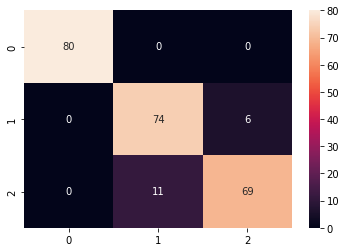

In [49]:
sns.heatmap(confusion_matrix(testLabels, testLabels_pred), annot = True)